# RNN With Integrator Training

Need torch=2.3.1 to work with torchtext 0.18 becaues torchtext is no longer
actively developed.

To set up, install: 

`python3 -m venv venv`

`source venv/bin/activate`

`pip3 install -r requirements.txt`

Then reload vscode and select the environment in vscode or jupyter

In [17]:
import torch
import torchtext; torchtext.disable_torchtext_deprecation_warning()
import os
from datasets import load_dataset
from torch.utils.data import DataLoader
import tqdm
import datetime
import json

torch.manual_seed(0)

# Setup Parameters

In [18]:
current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
BATCH_SIZE = 10

embedding_dim = 32
hidden_dim = 32
num_layers = 1
output_size = 1
NUM_EPOCHS = 2
vocab_min_freq = 10

# tag = "RNN_BASELINE"
# tag = "LSTM_BASELINE"
# tag = "BOW_BASELINE"
# tag = "LINEAR_RNN_BASELINE"
tag = "DEBUG"
EXP_DESC = f"{tag}, embedding_dim={embedding_dim}, hidden_dim={hidden_dim}, num_layers={num_layers}, output_size={output_size}, vocab_min_freq={vocab_min_freq}"

params = {
    "embedding_dim": embedding_dim,
    "hidden_dim": hidden_dim,
    "num_layers": num_layers,
    "output_size": output_size,
    "NUM_EPOCHS": NUM_EPOCHS,
    "vocab_min_freq": vocab_min_freq
}

experiment_dir = os.path.join("experiments", current_datetime + "_" + EXP_DESC)
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

json.dump(params, open(os.path.join(experiment_dir, "params.json"), "w"), indent=4)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)
print(EXP_DESC)

Device:  cuda
DEBUG, embedding_dim=32, hidden_dim=32, num_layers=1, output_size=1, vocab_min_freq=10


# Get Data

In [19]:
# https://huggingface.co/datasets/fancyzhx/yelp_polarity
ds = load_dataset("fancyzhx/yelp_polarity")
print("Column names: ", ds.column_names)

ds.set_format(type="torch", columns=["text", "label"])

train_data = ds["train"]
test_data = ds["test"]

Column names:  {'train': ['text', 'label'], 'test': ['text', 'label']}


# Do Tokenizing

In [20]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
import torch

tokenizer = get_tokenizer("basic_english")

vocab_path = f"assets/vocab_min{vocab_min_freq}.pt"

if not os.path.exists("assets"):
    os.makedirs("assets")

if os.path.exists(vocab_path):
    vocab = torch.load(vocab_path)
else:
    # Build vocabulary from the training dataset
    def yield_tokens(data):
        pbar = tqdm.tqdm(total=len(data))
        for example in data:
            pbar.update(1)
            yield tokenizer(example['text'])

    vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=["<unk>"], min_freq=vocab_min_freq)
    vocab.set_default_index(vocab["<unk>"])

    # Save vocab
    torch.save(vocab, vocab_path)

print("Vocab size: ", len(vocab))

100%|██████████| 560000/560000 [00:50<00:00, 11148.49it/s]


Vocab size:  54858


In [21]:
def tokenize_pipeline(sample):
    indexed = torch.tensor(vocab.lookup_indices(tokenizer(sample["text"])))
    return indexed

def label_pipeline(sample):
    return sample["label"]

In [22]:
def convert_to_words(tokens):
    if isinstance(tokens, torch.Tensor):
        tokens = tokens.tolist()
    return " ".join(vocab.lookup_tokens(tokens))

In [23]:
test_text = {"text": "This is a test sentence", "label": 1}
print(tokenize_pipeline(test_text))

tensor([  20,   14,    7, 2151, 7076])


In [24]:
def collate_fn(batch):
    texts = [tokenize_pipeline(sample) for sample in batch]
    labels = [label_pipeline(sample) for sample in batch]

    texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=0)

    labels = torch.tensor(labels)
    return texts, labels

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=False)

# Make Model

In [25]:
class LSTMModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)

        h_0 = torch.randn(num_layers, text.shape[0], hidden_dim).to(text.device)
        c_0 = torch.randn(num_layers, text.shape[0], hidden_dim).to(text.device)

        output, (h_n, c_n) = self.lstm(embedded, (h_0, c_0))
        # h_n is num_layers, batch_size, hidden_dim
        return self.sigmoid(self.fc(h_n[-1, :, :]))

    def get_latent_activations(self, text):
        embedded = self.embedding(text)

        h_0 = torch.randn(num_layers, text.shape[0], hidden_dim).to(text.device)
        c_0 = torch.randn(num_layers, text.shape[0], hidden_dim).to(text.device)

        output, (h_n, c_n) = self.lstm(embedded, (h_0, c_0))
        # h_n is num_layers, batch_size, hidden_dim
        return self.sigmoid(self.fc(h_n[-1, :, :])), output # N, L, H_out

class RNNModel(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)
        self.rnn= torch.nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)

        h_0 = torch.randn(num_layers, text.shape[0], hidden_dim).to(text.device)

        output, h_n = self.rnn(embedded, h_0)
        # h_n is num_layers, batch_size, hidden_dim
        return self.sigmoid(self.fc(h_n[-1, :, :]))

    def get_latent_activations(self, text):
        embedded = self.embedding(text)

        h_0 = torch.randn(num_layers, text.shape[0], hidden_dim).to(text.device)

        output, h_n = self.rnn(embedded, h_0)
        # h_n is num_layers, batch_size, hidden_dim
        return self.sigmoid(self.fc(h_n[-1, :, :])), output

class BagOfWords(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size):
        super(BagOfWords, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)

        self.fcs = []
        self.fcs.append(torch.nn.Linear(embedding_dim, hidden_dim))

        for layer in range(num_layers - 1):
            self.fcs.append(torch.nn.Linear(hidden_dim, hidden_dim))
        self.fcs = torch.nn.ModuleList(self.fcs)

        self.fcout = torch.nn.Linear(hidden_dim, output_size)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, text):
        x = self.embedding(text)

        for fc in self.fcs:
            x = self.relu(fc(x))
        h_out = self.fcout(x)
        prediction = self.sigmoid(torch.sum(h_out, dim=1, keepdim=False))

        return prediction

    def get_latent_activations(self, text):
        x = self.embedding(text)

        for fc in self.fcs:
            x = self.relu(fc(x))
        h_out = self.fcout(x)

        acts = torch.cumsum(h_out, dim=1)
        prediction = self.sigmoid(torch.sum(h_out, dim=1, keepdim=False))
        return prediction, acts

class HybridBagOfWords(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size):
        # Not used in final report
        super(HybridBagOfWords, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)

        # Bag of words
        self.fcs = []
        self.fcs.append(torch.nn.Linear(embedding_dim, hidden_dim))
        for layer in range(num_layers - 1):
            self.fcs.append(torch.nn.Linear(hidden_dim, hidden_dim))
        self.fcs = torch.nn.ModuleList(self.fcs)
        self.fcout = torch.nn.Linear(hidden_dim, output_size)

        # RNN
        self.rnn_hidden_dim = 4
        rnn_num_layers = num_layers
        self.rnn = torch.nn.RNN(embedding_dim, self.rnn_hidden_dim, num_layers=rnn_num_layers, batch_first=True)
        self.rnn_fcs = torch.nn.Linear(self.rnn_hidden_dim, output_size)


        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, text):
        x = self.embedding(text)

        # RNN
        h_0 = torch.randn(num_layers, text.shape[0], self.rnn_hidden_dim).to(text.device)
        output, h_n = self.rnn(x, h_0)  # output is batch_size, seq_len, hidden_dim
        output = self.rnn_fcs(output)

        # Bag of words
        for fc in self.fcs:
            x = self.relu(fc(x))
        h_out = self.fcout(x)

        integrated_rnn_output = torch.sum(output, dim=1, keepdim=False)
        integrated_bow_output = torch.sum(h_out, dim=1, keepdim=False)
        prediction = self.sigmoid(integrated_rnn_output + integrated_bow_output)

        return prediction

    def get_latent_activations(self, text):
        raise NotImplementedError("Not implemented")


class LatentBagOfWords(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size):
        # Not used in final report
        super(LatentBagOfWords, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)

        self.fcs = []
        self.fcs.append(torch.nn.Linear(embedding_dim, hidden_dim))

        for layer in range(num_layers - 1):
            self.fcs.append(torch.nn.Linear(hidden_dim, hidden_dim))
        self.fcs = torch.nn.ModuleList(self.fcs)

        self.fcout = torch.nn.Linear(hidden_dim, output_size)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, text):
        x = self.embedding(text)

        for fc in self.fcs:
            x = self.relu(fc(x))

        h_final = torch.sum(x, dim=1, keepdim=False)
        prediction = self.sigmoid(self.fcout(h_final))

        return prediction

    def get_latent_activations(self, text):
        x = self.embedding(text)

        for fc in self.fcs:
            x = self.relu(fc(x))

        h_final = torch.sum(x, dim=1, keepdim=False)

        acts = torch.cumsum(x, dim=1) # N, L, D
        prediction = self.sigmoid(self.fcout(h_final))
        return prediction, acts


def large_tanh(x):
    return 10 * torch.tanh(x / 10)

class LinearIntegratingRNN(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, output_size):
        super(LinearIntegratingRNN, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)

        if num_layers != 1:
            raise NotImplementedError("Only 1 layer is supported")


        self.V = torch.nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.eigenvalues_two_to_n = torch.nn.Parameter(torch.randn(hidden_dim - 1))
        self.one_tensor = torch.nn.Parameter(torch.tensor([1]), requires_grad=False)
        self.eye_tensor = torch.nn.Parameter(torch.eye(hidden_dim), requires_grad=False)

        # Matrix M is defined as M = V diag(-eigenvalues^2) V^-1
        # We always set the first eigenvalue to 0

        # Assume h0 is 0
        self.fcin = torch.nn.Linear(embedding_dim, hidden_dim)
        self.fcout = torch.nn.Linear(hidden_dim, output_size)

        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()
        self.act = torch.nn.Identity()  # Change to test different activations

    def forward(self, text):
        # Assume h0 is 0
        eigenvalues = torch.cat([self.one_tensor, self.tanh(self.eigenvalues_two_to_n)])
        M = self.V @ torch.diag(eigenvalues) @ self.V.inverse()
        W = M # Rename doesn't work in my IDE rn :(


        # Note, in theory you can calculate all powers of M and then do a matrix multiplication but
        # due to numerical instability, this is not recommended.
        # Calculate all powers of W
        # L = text.shape[1]
        # M_powers = M ** torch.arange(L -1, -1, -1).unsqueeze(1).unsqueeze(2).to(M.device)
        # h = torch.einsum("nld,ldk->nlk", x_in, M_powers)  # N, L, D
        # h_all = torch.cumsum(h, dim=1) # N, L, D

        x = self.embedding(text)
        x_in = self.fcin(x) # N, L, D

        # Simulate in loop
        h_all = torch.zeros(x_in.shape[0], x_in.shape[1], hidden_dim).to(x_in.device)
        h_t = torch.zeros(x_in.shape[0], hidden_dim).to(x_in.device)

        for t in range(text.shape[1]):
            preact = h_t @ W + x_in[:, t, :]
            h_t = self.act(preact)
            h_all[:, t, :] = h_t

        x_out = self.fcout(h_all[:, -1, :]) # N, D
        prediction = self.sigmoid(x_out)

        # This can happen if the system goes unstable (possible when using nonlinearities)
        if torch.isnan(prediction).any():
            print("NAN in M_powers")
            print("H all: ", h_all.shape)
            for line in h_all[0]:
                print(line)
            print(h_all[0])
            print(x_out)
            print(prediction)

        return prediction

    def get_latent_activations(self, text):
        # Get matrix
        eigenvalues = torch.cat([self.one_tensor, self.tanh(self.eigenvalues_two_to_n)])
        M = self.V @ torch.diag(eigenvalues) @ self.V.inverse()
        W = M

        x = self.embedding(text)
        x_in = self.fcin(x) # N, L, D

        # Simulate in loop
        # h_all is N, L, D
        h_all = torch.zeros(x_in.shape[0], x_in.shape[1], hidden_dim).to(x_in.device)
        h_t = torch.zeros(x_in.shape[0], hidden_dim).to(x_in.device)

        for t in range(text.shape[1]):
            h_t = self.act(h_t @ W + x_in[:, t, :])
            h_all[:, t, :] = h_t

        x_out = self.fcout(h_all[:, -1, :]) # N, D
        prediction = self.sigmoid(x_out)

        return prediction, h_all


# For example, make a LinearIntegratingRNN model
# model = LinearIntegratingRNN(len(vocab), embedding_dim, hidden_dim, num_layers, output_size).to(DEVICE)
# model = BagOfWords(len(vocab), embedding_dim, hidden_dim, num_layers, output_size).to(DEVICE)
# model = RNNModel(len(vocab), embedding_dim, hidden_dim, num_layers, output_size).to(DEVICE)
model = LSTMModel(len(vocab), embedding_dim, hidden_dim, num_layers, output_size).to(DEVICE)
loss = torch.nn.BCELoss().to(DEVICE)

print("Vocab size: ", len(vocab))
num_embedding_params = sum(p.numel() for p in model.embedding.parameters() if p.requires_grad)
print("Embedding params: ", num_embedding_params)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", num_params)
print("Number of model parameters: ", num_params - num_embedding_params)
print(model)

Vocab size:  54858
Embedding params:  1755456
Number of parameters:  1763937
Number of model parameters:  8481
LSTMModel(
  (embedding): Embedding(54858, 32)
  (lstm): LSTM(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


# Train model

In [26]:
from torch.utils.tensorboard import SummaryWriter

current_datetime = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
writer_dir = os.path.join("exp_runs", current_datetime + "_" + EXP_DESC)
writer = SummaryWriter(writer_dir)


# Set trial name:
writer.add_text("Trial name", "LSTM")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(NUM_EPOCHS):
    pbar = tqdm.tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    for i, (texts, labels) in pbar:
        texts = texts.to(DEVICE)
        labels = labels.to(DEVICE).float()

        optimizer.zero_grad()
        output = model(texts)
        # print(output)
        loss_val = loss(output, labels.unsqueeze(1))
        loss_val.backward()
        optimizer.step()

        if i % 100 == 0:
            writer.add_scalar("Loss/train", loss_val.item(), i + epoch * len(train_dataloader))

            pbar.set_description(f"Loss: {loss_val.item():.4f}")



    print("Epoch: ", epoch, " Loss: ", loss_val.item())

# Save model
torch.save(model.state_dict(), os.path.join(experiment_dir, f"model_{EXP_DESC}.pth"))

Loss: 0.0375: 100%|██████████| 56000/56000 [01:46<00:00, 526.46it/s]


Epoch:  0  Loss:  0.07797666639089584


Loss: 0.1014: 100%|██████████| 56000/56000 [01:46<00:00, 526.15it/s]

Epoch:  1  Loss:  0.05288456007838249


In [27]:
torch.save(model.state_dict(), os.path.join(experiment_dir, f"model_{EXP_DESC}.pth"))

In [28]:
# Validate
correct = 0
total = 0
with torch.no_grad():
    pbar = tqdm.tqdm(test_dataloader, total=len(test_dataloader))
    for texts, labels in pbar:
        texts = texts.to(DEVICE)
        labels = labels.to(DEVICE).float()

        output = model(texts)
        predictions = torch.round(output)

        total += labels.size(0)
        correct += (predictions.flatten() == labels.flatten()).sum().item()

print("Accuracy: ", correct / total)
print("")

100%|██████████| 3800/3800 [00:04<00:00, 923.16it/s]

Accuracy:  0.9567105263157895



In [29]:
# Sanity check with some test data
iterdata = iter(test_dataloader)
sample = next(iterdata)

texts, labels = sample
output = model(texts.to(DEVICE))
predictions = output

gt = labels.flatten().cpu().numpy()

for i in range(len(texts)):
    print(convert_to_words(list(texts[i])))
    print(predictions.flatten()[i].item(), gt[i].item())

contrary to other reviews , i have zero complaints about the service or the prices . i have been getting tire service here for the past 5 years now , and compared to my experience with places like pep boys , these guys are experienced and know what they ' re doing . \nalso , this is one place that i do not feel like i am being taken advantage of , just because of my gender . other auto mechanics have been notorious for capitalizing on my ignorance of cars , and have sucked my bank account dry . but here , my service and road coverage has all been well explained - and let up to me to decide . \nand they just renovated the waiting room . it looks a lot better than it did in previous years . <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <u

# Analysis

torch.Size([10, 376, 32])
torch.Size([376, 32])
torch.Size([3760, 32])
Variance explained:  [0.44819835 0.14067028]
(10, 376, 2)


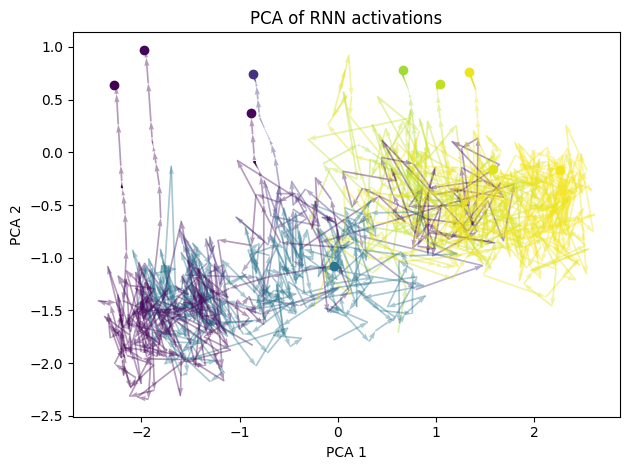

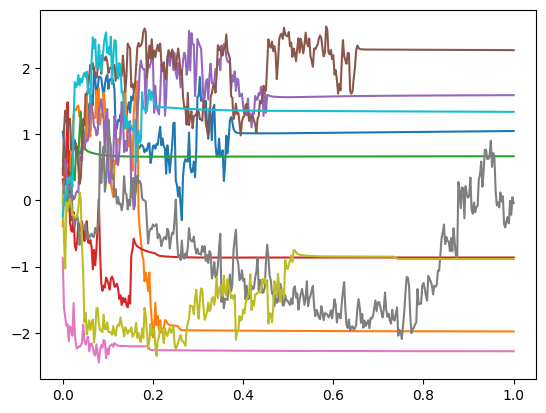

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# Examples on how to load a model to analyze.  Otherwise, just uses the model
# This will not work for the bag of words model

if isinstance(model, BagOfWords):
    raise NotImplementedError("Bag of words model does not support latent activations")

# # Load a bag of words for
# bag_of_words = BagOfWords(len(vocab), embedding_dim, hidden_dim, num_layers, output_size).to(DEVICE)
# weight_path = os.path.join("experiments",
# "20241208_155839_BOW_BASELINE, embedding_dim=32, hidden_dim=32, num_layers=1, output_size=1, vocab_min_freq=10",
# "model_BOW_BASELINE, embedding_dim=32, hidden_dim=32, num_layers=1, output_size=1, vocab_min_freq=10.pth")

# bag_of_words.load_state_dict(torch.load(weight_path))

# lstm_model = LSTMModel(len(vocab), embedding_dim, hidden_dim, num_layers, output_size).to(DEVICE)
# weight_path = os.path.join("experiments",
# "20241208_163603_LSTM_BASELINE, embedding_dim=32, hidden_dim=32, num_layers=1, output_size=1, vocab_min_freq=10",
# "model_LSTM_BASELINE, embedding_dim=32, hidden_dim=32, num_layers=1, output_size=1, vocab_min_freq=10.pth")
# lstm_model.load_state_dict(torch.load(weight_path))

# rnn_model = RNNModel(len(vocab), embedding_dim, hidden_dim, num_layers, output_size).to(DEVICE)
# weight_path = os.path.join("experiments",
# "20241208_181904_RNN_BASELINE, embedding_dim=32, hidden_dim=32, num_layers=1, output_size=1, vocab_min_freq=10",
# "model_RNN_BASELINE, embedding_dim=32, hidden_dim=32, num_layers=1, output_size=1, vocab_min_freq=10.pth")
# rnn_model.load_state_dict(torch.load(weight_path))

model_to_test = model

#



# Validate
iterdata = iter(test_dataloader)
sample = next(iterdata)
# sample = next(iterdata)
# sample = next(iterdata)

texts, labels = sample

# sample_idx = 0
# texts = texts[sample_idx:sample_idx + 1]
# labels = labels[sample_idx:sample_idx + 1]

predictions, acts = model_to_test.get_latent_activations(texts.to(DEVICE))
# Only works for bag of words since the plotting is different
# bow_predictions, bow_acts = bag_of_words.get_latent_activations(texts.to(DEVICE))

print(acts.shape)
acts_list = [act for act in acts]
print(acts_list[0].shape)
acts_stacked = torch.vstack(acts_list)
print(acts_stacked.shape)

pca = PCA(n_components=2)
pca.fit(acts_stacked.cpu().detach().numpy())
print("Variance explained: ", pca.explained_variance_ratio_)

acts_pca = pca.transform(acts_stacked.cpu().detach().numpy())
acts_batched = acts_pca.reshape(acts.shape[0], acts.shape[1], -1)
print(acts_batched.shape)

cmap = plt.get_cmap("viridis")


acts = []
for i in range(len(texts)):
    act = acts_batched[i]
    label = f"pred: {predictions.flatten()[i].item()}, gt: {labels.flatten()[i].item()}"
    prediction = predictions.flatten()[i].item()
    color = cmap(prediction)
    # plt.plot(act[:, 0], act[:, 1], label=label, color=color, alpha=0.4)

    # Plot quivers
    plt.quiver(act[:-1, 0], act[:-1, 1], act[1:, 0] - act[:-1, 0], act[1:, 1] -
    act[:-1, 1], scale_units='xy', angles='xy', scale=1, color=color, alpha=0.4)
    # plt.plot(act[:, 0], act[:, 1], ">", label=label, color=color, alpha=0.4)
    plt.plot(act[-1, 0], act[-1, 1], "o", color=color)
    acts.append(act)

    # Plot quiver for BOW
    # bow_act = bow_acts[i].cpu().detach().numpy()
    # bow_prediction = bow_predictions.flatten()[i].item()
    # bow_color = cmap(bow_prediction)

    # bow_act *= 0.4


plt.title("PCA of RNN activations")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.tight_layout()
plt.show()

for act in acts:
    plt.plot(np.linspace(0, 1, act.shape[0]), act[:, 0])